In [4]:
import pandas
import numpy
import conntility

fn_mat = "microns_mm3_connectome.h5"
name_dset_f = "full"
name_dset_c = "condensed"

M = conntility.ConnectivityMatrix.from_h5(fn_mat, name_dset_f)
C = conntility.ConnectivityMatrix.from_h5(fn_mat, name_dset_c)

The below is digitized from the image on https://www.microns-explorer.org/cortical-mm3 .

Each line is the digitized border between the indicated pairs of regions.
Yes, this is only a crude approximation.

In [66]:
lines = {
    ("visp", "visrl"): [[948.9304812834225, 1168.3783783783783],
[948.9304812834225, 1118.6486486486485],
[979.9465240641712, 1050.2702702702702],
[1010.9625668449198, 1019.1891891891892],
[1041.9786096256685, 963.2432432432432],
[1072.9946524064171, 904.1891891891892],
[1107.1122994652405, 832.7027027027027],
[1144.331550802139, 755],
[1147.433155080214, 683.5135135135135],
[1166.042780748663, 633.7837837837837],
[1162.9411764705883, 615.1351351351351],
[1172.2459893048128, 602.7027027027027]
],
    ("visp", "vislm"): [[1175.3475935828876, 602.7027027027027],
[1162.9411764705883, 562.2972972972973],
[1172.2459893048128, 509.45945945945937],
[1184.6524064171124, 450.4054054054053],
[1209.4652406417113, 375.81081081081084],
[1234.2780748663101, 288.78378378378375],
[1243.5828877005347, 189.32432432432438],
[1252.8877005347595, 24.594594594594582],
[1255.9893048128342, -87.29729729729729]
],
    ("vislm", "visrl"): [[1175.3475935828876, 602.7027027027027],
[1215.668449197861, 602.7027027027027],
[1259.0909090909092, 627.5675675675675],
[1283.9037433155079, 627.5675675675675]
],
    ("visal", "visrl"): [[1283.9037433155079, 627.5675675675675],
[1302.5133689839572, 671.081081081081],
[1324.2245989304813, 727.0270270270271],
[1355.24064171123, 807.8378378378378],
[1411.0695187165777, 904.1891891891892],
[1470, 988.1081081081081],
[1559.9465240641712, 1068.918918918919],
[1569.2513368983957, 1068.918918918919]
],
    ("vislm", "visal"):[[1283.9037433155079, 630.6756756756756],
[1314.9197860962568, 593.3783783783783],
[1358.342245989305, 568.5135135135135],
[1414.1711229946525, 528.1081081081081],
[1470, 487.7027027027027],
[1532.0320855614975, 453.51351351351354],
[1572.3529411764705, 453.51351351351354]
]
}
lines = dict([(k, numpy.array(v)) for k, v in lines.items()])

Plotting neuron densities and the digitized region borders.

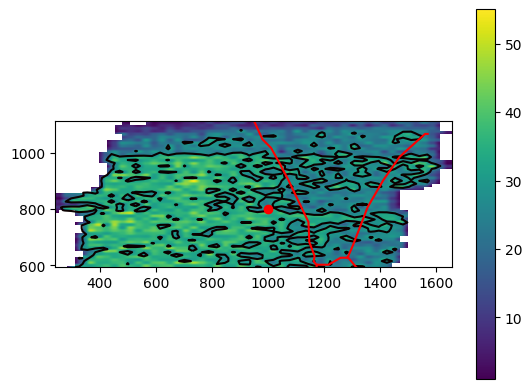

In [48]:
from matplotlib import pyplot as plt

nbins= 51
extents = {}
for col in ["x_nm", "y_nm", "z_nm"]:
    bins = numpy.linspace(C.vertices[col].min(), C.vertices[col].max() + 1, nbins)
    extents[col] = [bins[0] / 1000, bins[-1] / 1000]
    C.add_vertex_property(col + "_binned_{0}".format(nbins),
                         numpy.digitize(C.vertices[col], bins=bins))
    
I = C.vertices.groupby(["x_nm_binned_51",
                        "z_nm_binned_51"])["index"].count().unstack("x_nm_binned_51")

plt.colorbar(plt.imshow(I.values,
            extent=extents["x_nm"] + extents["z_nm"][::-1]))
plt.contour(I.values, cmap="hot", levels=[30.],
           extent=extents["x_nm"] + extents["z_nm"])
plt.gca().set_ylim(sorted(plt.gca().get_ylim()))

for k, v in lines.items():
    v
    plt.plot(v[:, 0], v[:, 1], color="red")
    
pt = numpy.array([1000, 800])
plt.plot(*pt, 'ro')

Algorithm to resolve which region a point is in, based on the region borders.

In [86]:
def distance_and_angle(lineseg, pt):
    dl = numpy.diff(lineseg, axis=0)[0]
    dl_n = dl / numpy.linalg.norm(dl)
    nrml = numpy.array([-dl_n[1], dl_n[0]])
    
    dp = pt - lineseg[0]
    side = numpy.sign(numpy.dot(nrml, dp))
    
    return side, numpy.linalg.norm(lineseg.mean(axis=0) - pt)

def resolve_side(ln, pt):
    side, dist = [list(_x) for _x in
        zip(*[
        distance_and_angle(ln[i:(i+2)], pt)
        for i in range(len(ln) - 1)
    ])]
    return side[numpy.argmin(dist)]

def resolve(pt):
    lst_regions = ["visp", "visrl", "vislm", "visal"]
    ruled_out = []
    for border, ln in lines.items():
        res = resolve_side(ln, pt)
        ruled_out.append(border[int(res < 0)])
    res_region = numpy.setdiff1d(lst_regions, ruled_out)
    assert len(res_region) == 1
    return lst_regions.index(res_region[0])

resolve(pt) # 0: VISP

0

Test for a grid of points

In [80]:
X, Y = numpy.meshgrid(numpy.linspace(300, 1600, 50),
                     numpy.linspace(600, 1100, 50))
pts = numpy.vstack([X.flatten(), Y.flatten()]).transpose()
import tqdm
lst_regions = ["visp", "visrl", "vislm", "visal"]

reg = [resolve(pt) for pt in tqdm.tqdm(pts)]
reg = numpy.array(reg).reshape(X.shape)


100%|██████████| 2500/2500 [00:05<00:00, 459.30it/s]


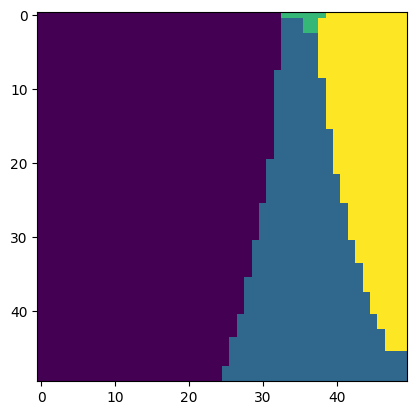

In [82]:
plt.imshow(reg)

For all neurons

In [93]:
tentative_region = C.vertices[["x_nm", "z_nm"]].apply(lambda x: resolve(x.values / 1000), axis=1)

C.add_vertex_property("tentative_region",
                      numpy.array(lst_regions)[tentative_region])

C.vertices

index          pt_root_id      id valid cell_type    pt_supervoxel_id   
0          0  864691134784325628  137038     t     5P_NP   79684632194875255  \
1          1  864691134792072188  137921     t       6CT   80529194831945862   
2          2  864691134807855033  768367     t       6IT  119721905279370531   
3          3  864691134832191490  671218     t       6IT  116552150024395943   
4          4  864691134854129537   27292     t        4P   75798544979690406   
...      ...                 ...     ...   ...       ...                 ...   
60043  60043  864691137197185345  264798     t     5P_IT   88610948491257700   
60044  60044  864691137197188161  296634     t        4P   90436069207709327   
60045  60045  864691137197196865  299940     t     5P_IT   89665379471159512   
60046  60046  864691137197197121  370191     t     5P_PT   95931772055213936   
60047  60047  864691137197212737  420736     t       23P   99858952577622162   

      status_dendrite status_axon     x_nm     y_nm    z_nm  indegree   
0               empty       empty   432448  1053696  880360       0.0  \
1               empty       empty   458240  1057792  944000       0.0   
2               empty       empty  1598720   979392  946720       0.0   
3               empty       empty  1506624   883648  746000       3.0   
4               empty       empty   321600   583680  620000       0.0   
...               ...         ...      ...      ...     ...       ...   
60043        extended         non   692544   741568  837240     367.0   
60044           empty       empty   747456   607616  863800     268.0   
60045           empty       empty   723456   708992  629040     138.0   
60046           empty       empty   906944   815104  913360     674.0   
60047           empty       empty  1021312   413568  877480      90.0   

       outdegree  x_nm_binned_51  y_nm_binned_51  z_nm_binned_51   
0            0.0               7              45              28  \
1            0.0               8              45              34   
2            1.0              49              41              34   
3            0.0              45              35              15   
4            0.0               3              17               3   
...          ...             ...             ...             ...   
60043      100.0              16              27              24   
60044      248.0              18              19              26   
60045      105.0              18              25               4   
60046      271.0              24              31              31   
60047       31.0              28               7              28   

      tentative_region  
0                 visp  
1                 visp  
2                visal  
3                visal  
4                 visp  
...                ...  
60043             visp  
60044             visp  
60045             visp  
60046             visp  
60047             visp  

[60048 rows x 17 columns]

Plot some examples

(185795.2, 1724668.8, 568508.0, 1139012.0)

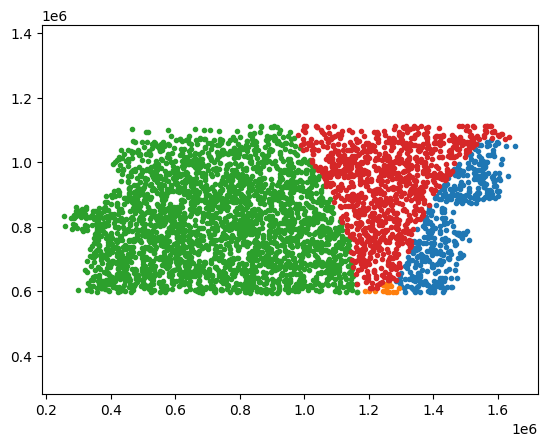

In [109]:
sel = numpy.random.choice(len(C.vertices), 4000, replace=False)
df = M.vertices.iloc[sel]

df.groupby("tentative_region").apply(
    lambda x: plt.plot(x["x_nm"], x["z_nm"], ls="None", marker='.')
)
plt.axis("equal")

Save results

In [110]:
M.to_h5(fn_mat, name_dset_f)
C.to_h5(fn_mat, name_dset_c)